In [ ]:
from config.default import get_default_config
from config.experiments import experiments
import sys
sys.path.append('/home/asaoulis/projects/transfer_sbi/transfer/')
from transfer_sbi.eval.utils import evaluate_best_checkpoint, parse_results, load_best_model_and_build_posterior
from transfer_sbi.eval.ensemble import evaluate_best_ensemble
import scienceplots
import matplotlib.pyplot as plt
# set fontsize to 18
plt.rcParams.update({'font.size': 18})
import os

plt.style.core.USER_LIBRARY_PATHS.append('.')
plt.style.reload_library()  # Reload styles


In [3]:
# check if cuda is available
import torch
print(torch.cuda.is_available())

True


In [4]:
def retrieve_first_list_from_experiments(experiments):
    list_key = None
    list_values = None
    for key, value in experiments.items():
        if isinstance(value, list):
            list_key = key
            list_values = value
            break
    return list_key,list_values


def load_config(experiment_name):
    experiment_config = experiments[experiment_name]
    list_key, list_values = retrieve_first_list_from_experiments(experiment_config)

    config = get_default_config()
    config.experiment_name = experiment_name
    # Set the non-list values
    for key, val in experiment_config.items():
        if key != list_key:
            setattr(config, key, val)
    return config


In [5]:
from transfer_sbi.utils import prepare_data_parameters
config = load_config('anneal_LH_illustris')
posteriors = {}
data_parameters = prepare_data_parameters(config)

Loading data from /share/gpu0/asaoulis/cmd/params_LH_IllustrisTNG.txt /share/gpu0/asaoulis/cmd/Maps_Mcdm_IllustrisTNG_LH_z=0.00.npy
Loading data from /share/gpu0/asaoulis/cmd/params_LH_IllustrisTNG.txt /share/gpu0/asaoulis/cmd/Maps_Mcdm_IllustrisTNG_LH_z=0.00.npy


In [7]:
all_results = {}
import os
for experiment_name in experiments.keys():
    experiment_path = f"/share/gpu0/asaoulis/cmd/checkpoints/{experiment_name}"

    if not os.path.exists(experiment_path):
        continue
    compiled_results = parse_results(experiment_name)
    all_results[experiment_name] = compiled_results
import pprint
# pprint.pprint(all_results, indent=4)

/home/asaoulis/.conda/envs/transfer-sbi/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/asaoulis/.conda/envs/transfer-sbi/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import re

plotting_name_conversions = {
    'test_log_prob': 'Mean Test Log Probability',
    'fom': 'Figure of Merit',
    'sample_ensemble_mse': 'Posterior Mean MSE',
    'ref_post_cov_mse': 'Sample Covariance MSE',
    'calibration_error': 'Calibration Error',
    'mse_0': '$\Omega_m$ MSE',
    'mse_1': '$\sigma_8$ MSE',
}

experiment_name_conversions = {
    'anneal_LH_illustris': 'Anneal',
    'finetune_LH_illustris': 'Transfer learning',
    'baseline_LH': '$N=12,000$',
    'scratch_LH_long': 'High fidelity only',
    "unpaired_LH_illustris": "Unpaired transfer learning",
    "freeze_CNN_LH_illustris": "Frozen CNN"
}

def plot_results(results, metric, experiment_names, match_strings=None, baseline_experiment=None, baseline_match_string=None, figsave=None):
    """
    Plots mean test_log_prob with standard error bars for selected experiments.
    Adds a horizontal dashed line for a baseline result if provided.
    
    Args:
        results (dict): Nested dictionary containing experiment results.
        metric (str): The metric to plot.
        experiment_names (list): List of top-level experiment names to include.
        match_string (str, optional): If provided, only second-level keys containing this string will be plotted.
        baseline_experiment (str, optional): Experiment name for baseline comparison.
        baseline_match_string (str, optional): String to match for selecting the baseline result.
    """
    plt.figure(figsize=(5, 4))

    # plt.figure(figsize=(6, 3))
    if match_strings is None:
        match_strings = [''] * len(experiment_names)
    
    for i, experiment in enumerate(experiment_names):
        if experiment not in results:
            print(f"Warning: {experiment} not found in results.")
            continue
        
        experiment_data = results[experiment]
        x_vals = []
        y_vals = []
        y_errs = []
        labels = []
        
        for run_name, metrics in experiment_data.items():
            match_string = match_strings[i]
            if (match_string and match_string not in run_name):
                continue
            if 'ensemble' in run_name and (not match_string or 'ensemble' not in match_string):
                continue
            
            match = re.search(r"ds(\d+)", run_name)
            if match:
                ds_size = int(match.group(1))
                if ds_size == 15000:
                    ds_size=0
                if 'ensemble' in run_name:
                    x_vals.append(ds_size)
                    y_vals.append(metrics[metric])
                    y_errs.append(0)
                    labels.append(run_name)
                else:

                    x_vals.append(ds_size)
                    y_vals.append(metrics[metric]['mean'])
                    y_errs.append(metrics[metric]['stderr'])
                    labels.append(run_name)
        if x_vals:
            x_vals, y_vals, y_errs, labels = zip(*sorted(zip(x_vals, y_vals, y_errs, labels)))
            exp_label = experiment_name_conversions.get(experiment, experiment)  # Use formatted name
            alpha = 1.0 if exp_label not in ["Transfer learning", "High fidelity only"] else 0.5
            plt.errorbar(x_vals, y_vals, yerr=y_errs, fmt='-o', alpha=1, label=exp_label, linewidth=2)
    
    if baseline_experiment and baseline_experiment in results:
        baseline_data = results[baseline_experiment]
        non_ensembles = {run_name: val for run_name, val in baseline_data.items() if 'ensemble' not in run_name}
        baseline_vals = [
            metrics[metric]['mean'] 
            for run_name, metrics in non_ensembles.items() 
            if not baseline_match_string or baseline_match_string in run_name
        ]
        if baseline_vals:
            baseline_mean = np.mean(baseline_vals)
            baseline_label = experiment_name_conversions.get(baseline_experiment, baseline_experiment)
            plt.axhline(y=baseline_mean, color='r', linestyle='--', label=f"Accurate ({baseline_label})")
    
    plt.xlabel("Dataset Size ($N$)")
    plt.ylabel(plotting_name_conversions.get(metric, metric))  # Use formatted metric name
    if metric == 'test_log_prob':
        plt.ylim([None, 4.5])
        plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    
    if 'log_prob' not in metric:
        plt.yscale('log')

    if figsave:
        plt.savefig(figsave, dpi=200, transparent=True)
    
    plt.show()

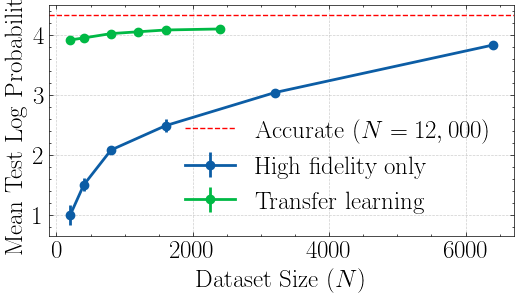

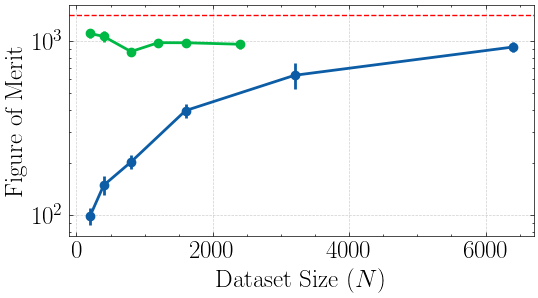

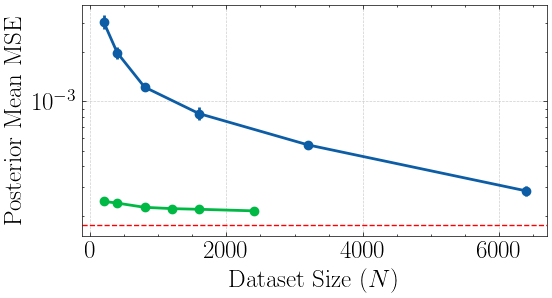

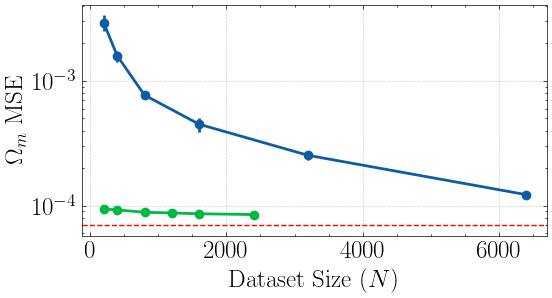

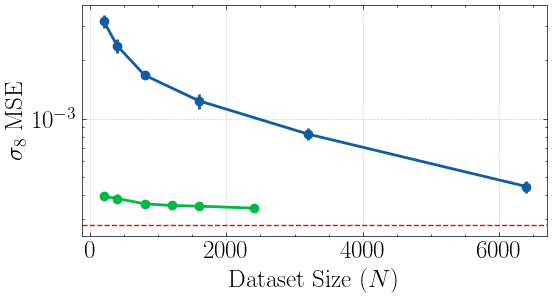

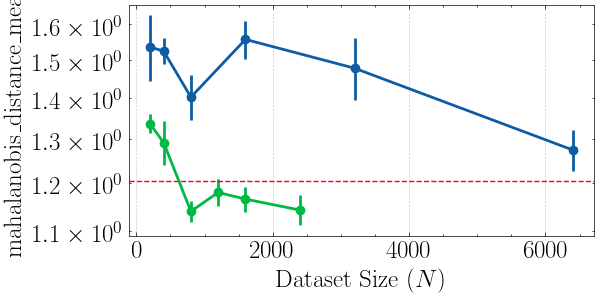

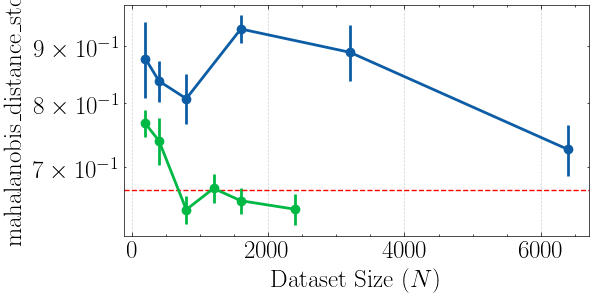

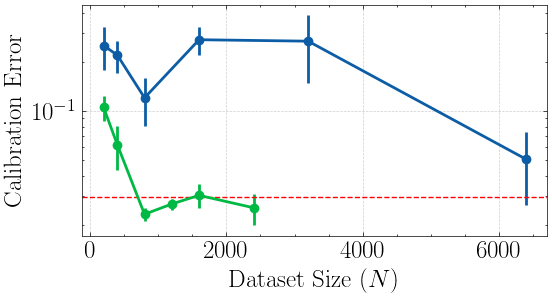

In [17]:

#['scratch_LH_long', 'finetune_LH_illustris', 'finetune_log_normal_LH']
with plt.style.context('science'):
    for metric in ['test_log_prob', 'fom', 'sample_ensemble_mse', 'mse_0', 'mse_1', 'mahalanobis_distance_mean', 'mahalanobis_distance_std']:
        plot_results(all_results, metric, ['scratch_LH_long', 'finetune_LH_illustris'], match_strings=['', '', '5e-05'],
                     baseline_experiment='baseline_LH', baseline_match_string='cyclic', figsave=f'plots/first_draft/LH/small_{metric}.svg')

    plot_results(all_results, 'calibration_error', ['scratch_LH_long', 'finetune_LH_illustris'], match_strings=['', '',],
                 baseline_experiment='baseline_LH', baseline_match_string='cyclic', figsave='plots/first_draft/LH/calibration_error.svg')


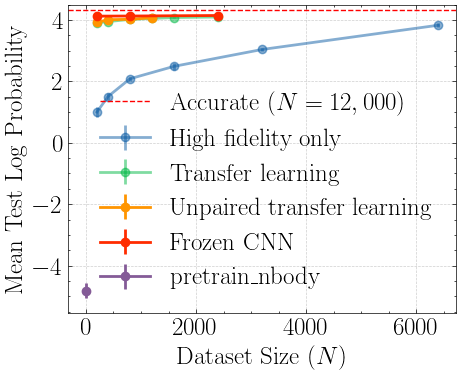

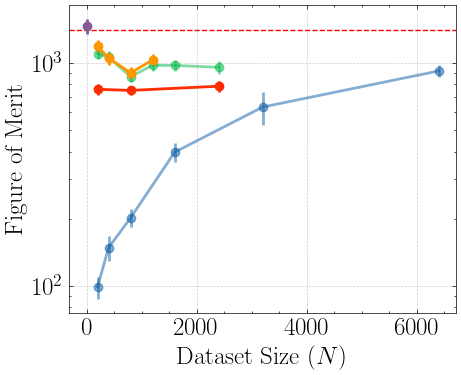

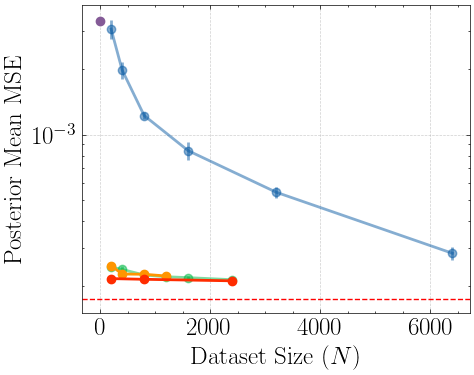

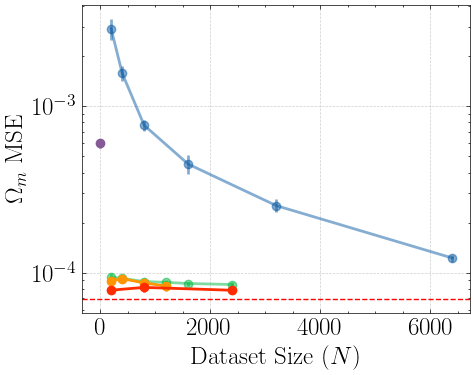

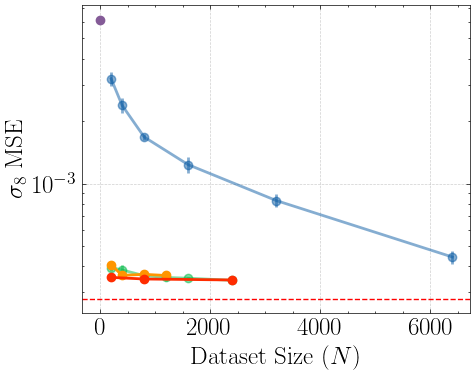

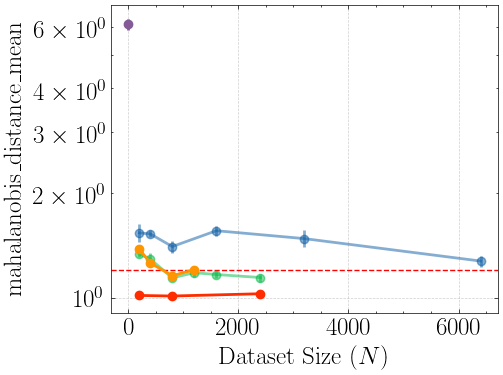

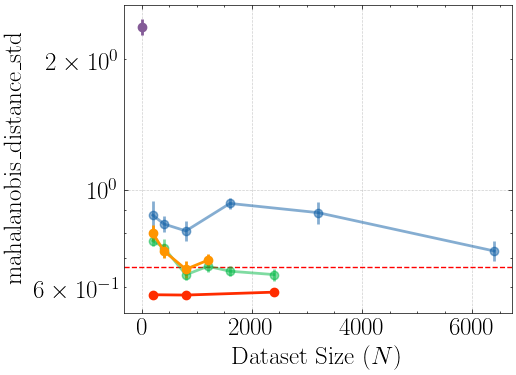

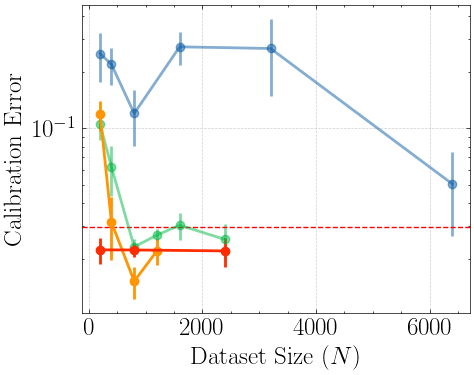

In [8]:

#['scratch_LH_long', 'finetune_LH_illustris', 'finetune_log_normal_LH']
with plt.style.context('science'):
    for metric in ['test_log_prob', 'fom', 'sample_ensemble_mse', 'mse_0', 'mse_1', 'mahalanobis_distance_mean', 'mahalanobis_distance_std']:
        plot_results(all_results, metric, ['scratch_LH_long', 'finetune_LH_illustris', "unpaired_LH_illustris", 'freeze_CNN_LH_illustris', 'pretrain_nbody'], match_strings=['', '', '', '', 'cyclic'],
                     baseline_experiment='baseline_LH', baseline_match_string='cyclic', figsave=f'plots/first_draft/LH/{metric}_appendix.svg')

    plot_results(all_results, 'calibration_error', ['scratch_LH_long', 'finetune_LH_illustris', "unpaired_LH_illustris", 'freeze_CNN_LH_illustris'], match_strings=['', '','', ''],
                 baseline_experiment='baseline_LH', baseline_match_string='cyclic', figsave='plots/first_draft/LH/calibration_error_appendix.svg')


In [ ]:
params = {'High fidelity only, $N=800$': ('scratch_LH_long', 'ds800'), 'Transfer learning, $N=800$': ('finetune_LH_illustris', 'ds800'),  'Accurate, $N=12000$': ('baseline_LH', 'exp')}

posteriors = {}
for name, (experiment_name, ds_string) in params.items():
    config = load_config(experiment_name)
    posterior, test_dataloader, scalers = load_best_model_and_build_posterior(config, ds_string_match=ds_string, data_parameters=data_parameters)
    posteriors[name] = posterior.build_posterior_object()

/home/asaoulis/.conda/envs/transfer-sbi/lib/python3.10/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(
/home/asaoulis/.conda/envs/transfer-sbi/lib/python3.10/site-packages/sbi/utils/user_input_checks.py:711: UserWarning: Data x has device 'cpu'.Moving x to the data_device 'cuda:0'.Training will proceed on device 'cuda:0'.
  warnings.warn(
/home/asaoulis/.conda/envs/transfer-sbi/lib/python3.10/site-packages/sbi/utils/user_input_checks.py:719: UserWarning: Parameters theta has device 'cpu'. Moving theta to the data_device 'cuda:0'.Training will proceed on device 'cuda:0'.
  warnings.warn(


In [ ]:
from chainconsumer import Chain, PlotConfig, Truth, ChainConsumer, ChainConfig
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})


columns = [r"$\Omega_\textrm{m}$", "$\sigma_8$"]
cmap = plt.get_cmap('plasma')
plotting_kwargs_dict = {
    'Accurate': dict(color='red', linewidth=2, shade=False),
    'Finetune': dict(color='green', contrast=0.8),
    'Scratch': dict(color='blue'),
}
# convert to posterior dict keys if Accurate in name
plotting_kwargs = {}
for name, kwargs in plotting_kwargs_dict.items():
    for key in posteriors.keys():
        if name in key:
            plotting_kwargs[key] = kwargs
            break
test_y, test_x = test_dataloader.dataset.tensors
np.random.seed(10)
idx = np.random.permutation(len(test_y))
test_y = test_y[idx]
test_x = test_x[idx]

param_scaler, data_scaler = scalers

for i in range(10):
    c = ChainConsumer()
    j = 0
    for name, accurate_posterior_sbi in posteriors.items():

        scaled_y = test_y[-i] 
        y = scaled_y.to('cuda', dtype=torch.float32).unsqueeze(1)
        x = param_scaler.inverse_transform_minmax(test_x[-i])
        samples_cheap = accurate_posterior_sbi.sample((50000,), x=y, show_progress_bars=False)

        vals = samples_cheap.detach().cpu().numpy()
        vals = param_scaler.inverse_transform_minmax(vals)
        cheap_samples_df = pd.DataFrame(vals, columns=columns)
        cheap_samples = Chain(samples=cheap_samples_df, parameters=columns, name=name, **plotting_kwargs.get(name, {}), zorder=j)
        c.add_chain(cheap_samples)
        j +=1


    c.set_plot_config(
        PlotConfig(
            flip=True,
            tick_font_size=16,
            label_font_size=16,
            contour_label_font_size=20,
            legend_kwargs={"loc": "upper left"},
            serif=True,
            usetex=True,
        )
    )

    truth_dict = {column: x[i] for i, column in enumerate(columns)}
    c.add_truth(Truth(location=truth_dict, marker="x", color="black", label="Truth"))

    fig = c.plotter.plot(figsize=(5, 5), )
    plt.show()
